# Chapter 20
## Chemical Synapses

In [2]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from input_factory import get_step_current

In [3]:
def plot_data(state_monitor, title=None, c='k'):
    """Plots the state_monitor variables "vm" vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    fig, ax = plt.subplots(1, figsize=(10, 3))

    ax.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c=c)

    ax.set_xlabel("t [ms]")
    ax.set_ylabel("v [mV]")

    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        -100, 50))

    if title is not None:
        ax.set_title(title)

    plt.show();

### 20.1 Nearly Instantaneous Rise

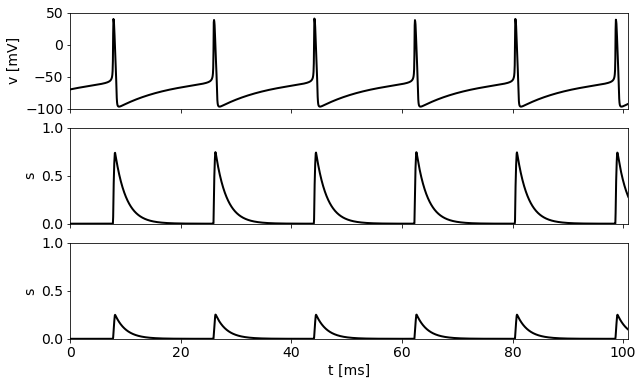

In [68]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp


def simulate_RTM_neuron(I_e=1.5 *b2.uA, 
                        tau_r=0.2 *b2.ms, 
                        simulation_time=101 * b2.ms):

    """A Reduced Traub-Miles Model neuron implemented in Brian2.
    """

    # neuron parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    C = 1 * b2.ufarad
#     tau_r = 0.2 *b2.ms
    tau_d = 2 *b2.ms

    # forming RTM model with differential equations
    eqs = """
    
    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz
    
    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz

    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    ds/dt = 0.5 * (1 + tanh(0.1*vm/mV)) * (1-s)/tau_r - s/tau_d : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    

    neurons = b2.NeuronGroup(1, eqs, method="rk4", dt=0.05*b2.ms)
    
    neurons.vm = -70.0*b2.mV
    neurons.m = "alpham / (alpham + betam)"
    neurons.h = "alphah / (alphah + betah)"
    neurons.n = "alphan / (alphan + betan)"
    neurons.s = 0.0
    
    # tracking parameters
    st_mon = b2.StateMonitor(neurons, ["vm", "s"], record=[0, 1])

    # running the simulation
    net = b2.Network(neurons)
    net.add(st_mon)
    net.run(simulation_time)

    return st_mon

state_monitor = simulate_RTM_neuron(1.5 *b2.uA, 0.2 *b2.ms, 101 * b2.ms)

fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True)
ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c="k")
ax[1].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")

state_monitor = simulate_RTM_neuron(1.5 *b2.uA, 1 *b2.ms, 101 * b2.ms)
ax[2].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")

ax[2].set_xlabel("t [ms]", fontsize=14)
ax[0].set_ylabel("v [mV]", fontsize=14)
ax[1].set_ylabel("s", fontsize=14)
ax[2].set_ylabel("s", fontsize=14)
ax[0].set_xlim([0, np.max(state_monitor.t / b2.ms)])
ax[0].set_ylim([-100, 50])
for i in range(3):
    ax[i].tick_params(labelsize=14)
for i in range(1,3):
    ax[i].set_ylim(0,1)

### 20.2 Gradual Rise

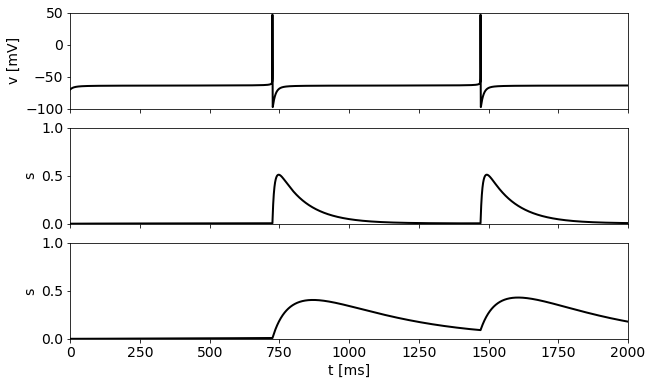

In [69]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp


def simulate_RTM_neuron(I_e=1.5 *b2.uA, 
                        tau_r=0.2 *b2.ms, 
                        tau_d=2.0 *b2.ms,
                        tau_d_q = 10*b2.ms,
                        simulation_time=101 * b2.ms):

    """A Reduced Traub-Miles Model neuron implemented in Brian2.
    """

    # neuron parameters
    El = -67 * b2.mV
    EK = -100 * b2.mV
    ENa = 50 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 80 * b2.msiemens
    gNa = 100 * b2.msiemens
    C = 1 * b2.ufarad

    # forming RTM model with differential equations
    eqs = """
    
    alphah = 0.128 * exp(-(vm + 50.0*mV) / (18.0*mV))/ms :Hz
    alpham = 0.32/mV * (vm + 54*mV) / (1.0 - exp(-(vm + 54.0*mV) / (4.0*mV)))/ms:Hz
    alphan = 0.032/mV * (vm + 52*mV) / (1.0 - exp(-(vm + 52.0*mV) / (5.0*mV)))/ms:Hz
    
    betah  = 4.0 / (1.0 + exp(-(vm + 27.0*mV) / (5.0*mV)))/ms:Hz
    betam  = 0.28/mV * (vm + 27.0*mV) / (exp((vm + 27.0*mV) / (5.0*mV)) - 1.0)/ms:Hz
    betan  = 0.5 * exp(-(vm + 57.0*mV) / (40.0*mV))/ms:Hz

    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    # ds/dt = 0.5 * (1 + tanh(0.1*vm/mV)) * (1-s)/tau_r - s/tau_d : 1
    
    dq/dt = 0.5 * (1+tanh(0.1 * vm/mV))*(1-q)*10.0/ms-q/tau_d_q : 1
    ds/dt = q * (1 - s)/tau_r - s/tau_d : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    

    neurons = b2.NeuronGroup(1, eqs, method="euler", dt=0.01*b2.ms)
    
    neurons.vm = -70.0*b2.mV
    neurons.m = "alpham / (alpham + betam)"
    neurons.h = "alphah / (alphah + betah)"
    neurons.n = "alphan / (alphan + betan)"
    neurons.s = 0.0
    neurons.q = 0.0
    
    # tracking parameters
    st_mon = b2.StateMonitor(neurons, ["vm", "s"], record=[0, 1])

    # running the simulation
    net = b2.Network(neurons)
    net.add(st_mon)
    net.run(simulation_time)

    return st_mon

state_monitor = simulate_RTM_neuron(0.12 *b2.uA, 
                                    tau_r=10 *b2.ms, 
                                    tau_d=100*b2.ms,
                                    tau_d_q=10*b2.ms,
                                    simulation_time=2001 * b2.ms)

fig, ax = plt.subplots(3, figsize=(10, 6), sharex=True)
ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c="k")
ax[1].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")


state_monitor = simulate_RTM_neuron(0.12 *b2.uA, 
                                    tau_r=100 *b2.ms, 
                                    tau_d=300*b2.ms,
                                    tau_d_q=100*b2.ms,
                                    simulation_time=2001 * b2.ms)

ax[2].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")

ax[2].set_xlabel("t [ms]", fontsize=14)
ax[0].set_ylabel("v [mV]", fontsize=14)
ax[1].set_ylabel("s", fontsize=14)
ax[2].set_ylabel("s", fontsize=14)
ax[0].set_xlim([0, np.max(state_monitor.t / b2.ms)])
ax[0].set_ylim([-100, 50])
for i in range(3):
    ax[i].tick_params(labelsize=14)
for i in range(1,3):
    ax[i].set_ylim(0,1)

#### Buildup of the Synaptic Gating Variable over Multiple Action Potentials

(0.0, 1.0)

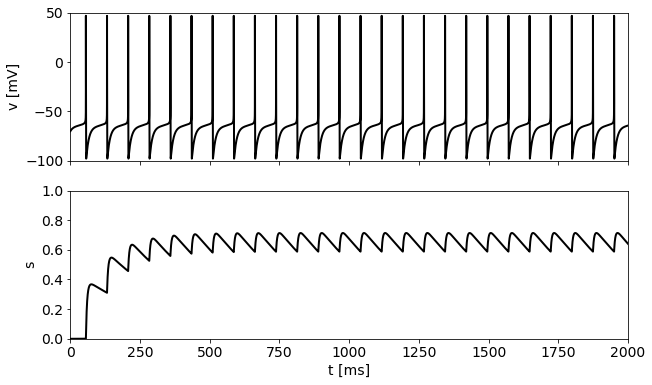

In [70]:
state_monitor = simulate_RTM_neuron(0.2 *b2.uA, 
                                    tau_r=10 *b2.ms, 
                                    tau_d=300*b2.ms,
                                    tau_d_q=5*b2.ms,
                                    simulation_time=2001 * b2.ms)

fig, ax = plt.subplots(2, figsize=(10, 6), sharex=True)
ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c="k")
ax[1].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")


ax[1].set_xlabel("t [ms]", fontsize=14)
ax[0].set_ylabel("v [mV]", fontsize=14)
ax[1].set_ylabel("s", fontsize=14)
ax[0].set_xlim([0, np.max(state_monitor.t / b2.ms)])
ax[0].set_ylim([-100, 50])
for i in range(2):
    ax[i].tick_params(labelsize=14)

ax[1].set_ylim(0,1)

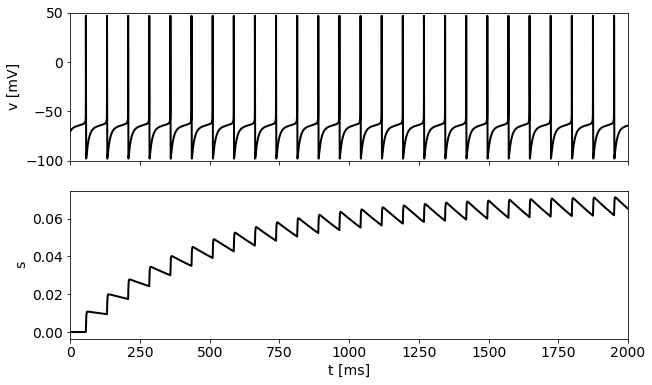

In [71]:
b2.start_scope()
state_monitor = simulate_RTM_neuron(0.2 *b2.uA, 
                                    tau_r=100 *b2.ms, 
                                    tau_d=500*b2.ms,
                                    tau_d_q=1*b2.ms,
                                    simulation_time=2001 * b2.ms)

fig, ax = plt.subplots(2, figsize=(10, 6), sharex=True)
ax[0].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c="k")
ax[1].plot(state_monitor.t / b2.ms, state_monitor.s[0], lw=2, c="k")


ax[1].set_xlabel("t [ms]", fontsize=14)
ax[0].set_ylabel("v [mV]", fontsize=14)
ax[1].set_ylabel("s", fontsize=14)
ax[0].set_xlim([0, np.max(state_monitor.t / b2.ms)])
ax[0].set_ylim([-100, 50])
for i in range(2):
    ax[i].tick_params(labelsize=14)

# ax[1].set_ylim(0,1)